## CSC 215 - Project 2
### Khoi Hoang
### William Dobson

In [ ]:
import os
import csv
import json
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import sklearn.feature_extraction.text as sk_text

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


### Convert JSON data into tabular format for Pandas

In [ ]:
#reviews.json
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

In [ ]:
#business.json
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count', 'categories'])
with open('business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], row['review_count'], row['categories']])

outfile.close()

In [ ]:
#tip.json
outfile = open("tip.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','text'])
with open('tip.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], (row['text']).encode('utf-8')])

outfile.close()

In [3]:
df_review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")
df_tip= pd.read_csv('tip.tsv', delimiter ="\t", encoding="utf-8")
df_tip[0:5]

,business_id,text
0,VaKXUpmWTTWDKbpJ3aQdMw,"b'Great for watching games, ufc, and whatever ..."
1,OPiPeoJiv92rENwbq76orA,b'Happy Hour 2-4 daily with 1/2 price drinks a...
2,5KheTjYPu1HcQzQFtm4_vw,b'Good chips and salsa. Loud at times. Good se...
3,TkoyGi8J7YFjA6SbaRzrxg,b'The setting and decoration here is amazing. ...
4,AkL6Ous6A1atZejfZXn1Bg,b'Molly is definately taking a picture with Sa...


In [4]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [5]:
#only consider reviews that have more than 50 characters
df_review = df_review[df_review['text'].str.len() >= 50]
df_review.shape

(6678404, 3)

In [6]:
df_tip = df_tip[df_tip['text'].str.len() >= 20]
df_tip.shape

(1094522, 2)

In [7]:
#group all reviews by each business and create a new dataframe, where each line is a business with all its reviews
df_review_agg = df_review.groupby('business_id')['text'].sum()

df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [8]:
#group all tip by each business and create a new dataframe, where each line is a business with all its tips
df_tip_agg = df_tip.groupby('business_id')['text'].sum()

df_all_tips = pd.DataFrame({'business_id': df_tip_agg.index, 'all_tips': df_tip_agg.values})

In [9]:
df_all_tips.head()

,business_id,all_tips
0,--1UhMGODdWsrMastO9DZw,"b""Delicious! One of the best burritos, salsa a..."
1,--6MefnULPED_I942VcFNA,b'BBQ pork is sold out early on Saturday'b'The...
2,--7zmmkVg-IMGaXbuVd0SQ,"b""Good place to stop when traffic don't go.""b'..."
3,--9QQLMTbFzLJ_oT-ON3Xw,"b""Tip? Don't get your hair cut here. If they'r..."
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Wine pairings for my prix fixe meal. Mmmm'b...


#### Only consider businesses which have more than 20 reviews

In [10]:
df_business = df_business[df_business['review_count'] >= 20]
df_business.shape

(57644, 4)

In [11]:
#merge df_business, df_all_reviews, and df_all_tips by business_id
#df_ready_for_sklearn = pd.merge(pd.merge(df_all_reviews, df_business, on='business_id', how='inner'), df_all_tips, on='business_id', how='inner')
df_ready_for_sklearn = pd.merge(df_all_reviews, df_business, on='business_id', how='inner')
df_ready_for_sklearn.shape

(57644, 5)

In [17]:
df_ready_for_sklearn.isnull().any()

business_id     False
all_reviews     False
stars           False
review_count    False
categories       True
dtype: bool

In [18]:
#label encode the stars
le = preprocessing.LabelEncoder()
df_ready_for_sklearn['encoded_stars'] = le.fit_transform(df_ready_for_sklearn['stars'])

In [19]:
print(df_ready_for_sklearn.shape)
df_ready_for_sklearn[0:5]

(57644, 6)


,business_id,all_reviews,stars,review_count,categories,encoded_stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,4.0,24,"Restaurants, Mexican",6
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",3.0,44,"Chinese, Restaurants",4
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food",6
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",6
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",5


## Split the data and prepare for training and testing

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [21]:
x_train['review_count_zscore'] = zscore(x_train['review_count'])
x_train[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,encoded_stars,review_count_zscore
13124,DYi6jJYhK3kTfaYn81tORQ,"b""Great little place. \n\nSimple, comfy, low-k...",4.5,22,"Burgers, Nightlife, Karaoke, Chicken Wings, Ar...",7,-0.388956
48569,q0PKLCgApK5XynhaZAY3EA,"b""Great experience at Shoe Therapy. I brought...",4.5,24,"Local Services, Fashion, Shopping, Leather Goo...",7,-0.378257
50871,sZv5q1vMP2-G3z1stxNrOw,b'The salon was clean and they did a great job...,3.5,48,"Hair Removal, Skin Care, Nail Salons, Beauty &...",5,-0.249863
55316,xULATz2siGXOPia614mg2A,"b'Oh, college. When I think back on off-campus...",3.0,394,"Chinese, Vegetarian, Pan Asian, Restaurants, J...",4,1.601145
50459,s6lTNO57vXsfzyYrPfXOvA,"b""The chicken over broken rice tastes no so go...",4.0,349,"Vietnamese, Restaurants",6,1.360407


In [22]:
x_test['review_count_zscore'] = zscore(x_test['review_count'])
x_test[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,encoded_stars,review_count_zscore
5538,55lgqZ_IVMHCuAfqSHx_CQ,b'We had the best time tonight on this heli tr...,5.0,56,"Education, Specialty Schools, Vocational & Tec...",8,-0.217415
7593,7QAwB7CV5BmSpU3uCWlfeA,"b""I bought my Yamaha TW200 from these guys. \n...",4.0,27,"Motorcycle Dealers, Shopping, Motorcycle Gear,...",6,-0.371616
17961,Iqu-RwRA4XfwILKQLKQZew,"b""Do yourself a favor and try the chaats. We h...",3.5,56,"Indian, Bakeries, Restaurants, Food",5,-0.217415
39121,fMdfTMXQBioNlfcZsD1gOw,"b""I bought a group on deal for a swedish massa...",4.0,189,"Day Spas, Beauty & Spas, Massage, Skin Care",6,0.489787
56861,z9aXGRH8xtqpNDFE5_I3KA,"b""received a mailer and thought okay let's go...",4.0,86,"Restaurants, Bars, Nightlife, American (Tradit...",6,-0.057896


In [26]:
#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=0.05)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '15',
 '20',
 '30',
 '50',
 'able',
 'absolutely',
 'actually',
 'add',
 'ago',
 'amazing',
 'appetizer',
 'appointment',
 'area',
 'arrived',
 'ask',
 'asked',
 'ate',
 'atmosphere',
 'attentive',
 'authentic',
 'available',
 'average',
 'away',
 'awesome',
 'bacon',
 'bad',
 'bar',
 'bbq',
 'beautiful',
 'beef',
 'beer',
 'believe',
 'best',
 'better',
 'big',
 'birthday',
 'bit',
 'bite',
 'bowl',
 'bread',
 'breakfast',
 'bring',
 'brought',
 'brunch',
 'buffet',
 'burger',
 'burgers',
 'business',
 'busy',
 'buy',
 'cake',
 'called',
 'came',
 'car',
 'card',
 'care',
 'change',
 'charge',
 'cheap',
 'check',
 'cheese',
 'chef',
 'chicken',
 'chinese',
 'chips',
 'chocolate',
 'choice',
 'choose',
 'city',
 'clean',
 'close',
 'coffee',
 'cold',
 'come',
 'comes',
 'comfortable',
 'coming',
 'company',
 'completely',
 'cooked',
 'cool',
 'cost',
 'couldn',
 'counter',
 'couple',
 'course',
 'crab',
 'cream',
 'crispy',
 'customer',
 'customers',
 'cut',
 'day',
 'days',
 '

In [47]:
y_train.head()

13124    4.5
48569    4.5
50871    3.5
55316    3.0
50459    4.0
Name: stars, dtype: float64

In [ ]:
#obtain tfidf score for tips
#vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=10)

#tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
#tips_tfidf_train = tips_matrix_train.toarray()

#tips_matrix_test = vectorizer.transform(x_test['all_tips'])
#tips_tfidf_test = tips_matrix_test.toarray()

#vectorizer.get_feature_names()

In [28]:
temp = x_train['review_count_zscore'].values
#input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
#input_data_train = np.column_stack((input_data_train, temp))
input_data_train = np.column_stack((reviews_tfidf_train, temp))
input_data_train.shape

temp = x_test['review_count_zscore'].values
#input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
#input_data_test = np.column_stack((input_data_test, temp))
input_data_test = np.column_stack((reviews_tfidf_test, temp))
input_data_test.shape

(14411, 501)

In [48]:
type(input_data_train)

numpy.ndarray

In [49]:
#convert into dataframe
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
df_train['stars'] = y_train.values
df_test['stars'] = y_test.values
#df_train.dropna()
#missing_median(df_train, 'stars')
#missing_median(df_test, 'stars')

In [52]:
df_test.isnull().values.any()

False

In [34]:
df_train.shape

(43233, 502)

In [53]:
x_train_tf,y_train_tf = to_xy(df_train,'stars')

In [54]:
x_test_tf,y_test_tf = to_xy(df_test,'stars')

In [55]:
y_train_tf

array([4.5, 4.5, 3.5, ..., 4.5, 3.5, 4.5], dtype=float32)

# Tensorflow

### Regression model

In [56]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


In [62]:
model = Sequential()

model.add(Dense(100, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(200, activation='relu')) # Hidden 2
model.add(Dense(300, activation='relu')) # Hidden 3
model.add(Dense(200, activation='relu')) # Hidden 4
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model


model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.


Train on 43233 samples, validate on 14411 samples
Epoch 1/1000
 - 6s - loss: 0.2476 - val_loss: 0.1162
Epoch 2/1000
 - 5s - loss: 0.0864 - val_loss: 0.0801
Epoch 3/1000
 - 5s - loss: 0.0783 - val_loss: 0.0891
Epoch 4/1000
 - 5s - loss: 0.0757 - val_loss: 0.1199
Epoch 5/1000
 - 5s - loss: 0.0702 - val_loss: 0.0798
Epoch 6/1000
 - 5s - loss: 0.0683 - val_loss: 0.0710
Epoch 7/1000
 - 5s - loss: 0.0657 - val_loss: 0.0725
Epoch 8/1000
 - 5s - loss: 0.0624 - val_loss: 0.0716
Epoch 9/1000
 - 5s - loss: 0.0587 - val_loss: 0.0741
Epoch 10/1000
 - 5s - loss: 0.0574 - val_loss: 0.0727
Epoch 11/1000
 - 5s - loss: 0.0536 - val_loss: 0.0950
Epoch 00011: early stopping


In [63]:
pred = model.predict(x_test_tf)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (14411, 1)
[[4.565313 ]
 [3.9358768]
 [3.6168494]
 ...
 [4.049435 ]
 [4.210229 ]
 [3.112597 ]]


In [64]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test_tf))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.3082558810710907


In [68]:
y_test_tf.shape

(14411,)

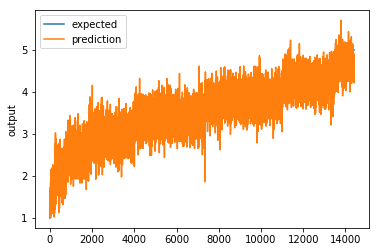

In [65]:
# Plot the chart
chart_regression(pred.flatten(),y_test_tf)

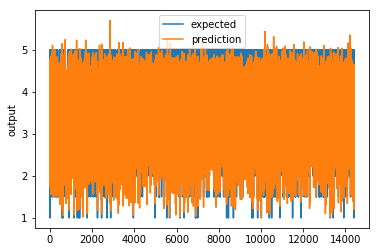

In [66]:
chart_regression(pred.flatten(),y_test_tf, sort=False)

### Use tfidfVectorizer to obtain TFIDF representation for each business

In [ ]:
#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

reviews_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])

reviews_tfidf = reviews_matrix.toarray()

In [ ]:
print(reviews_tfidf.shape)
vectorizer.get_feature_names()

In [ ]:
#obtain tfidf score for tips
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

tips_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_tips'])

tips_tfidf = tips_matrix.toarray()

In [ ]:
print(tips_tfidf[0:5])
vectorizer.get_feature_names()

# Linear Regression

Preparing data for training/testing

In [ ]:
#Merge reviews_tfidf, tips_tfidf and review_count into one array for input
temp = df_ready_for_sklearn['review_count_zscore'].values
input_data = np.column_stack((reviews_tfidf, tips_tfidf))
input_data = np.column_stack((input_data, temp))
input_data.shape

In [ ]:
#split into train/test data
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [ ]:
test_data = input_data[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data[test_loc[i]], axis=0)
test_data.shape

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Linear = linreg.predict(test_data)

In [ ]:
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Linear[i], test_true_stars[i]))

### Support Vector Machine

In [ ]:
#split into train/test data
#using encoded stars because classification problem
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual=False)
clf.fit(x_train, y_train)

y_pred_SVM = clf.predict(test_data)

In [ ]:
y_pred_SVM = le.inverse_transform(y_pred_SVM)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_SVM[i], test_true_stars[i]))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Logistic = logreg.predict(test_data)

In [ ]:
y_pred_Logistic = le.inverse_transform(y_pred_Logistic)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Logistic[i], test_true_stars[i]))

### Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(x_train, y_train)

In [ ]:
# predict the response for new observations
y_neighbor = knn.predict(test_data)

In [ ]:
y_neighbor = le.inverse_transform(y_neighbor)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_neighbor[i], test_true_stars[i]))

### Multinomial Naive Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(df_ready_for_sklearn['review_count'].values.reshape(1, -1))

input_data_MNB = np.column_stack((reviews_tfidf, tips_tfidf))
input_data_MNB = np.column_stack((input_data_MNB, temp.reshape(-1,1)))

input_data_MNB

In [ ]:
test_data = input_data_MNB[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data_MNB[test_loc[i]], axis=0)
test_data.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_data_MNB, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model (using the default parameters)
mnb = MultinomialNB()

# fit the model with data
mnb.fit(x_train, y_train)

# predict the response for new observations
y_mnb = mnb.predict(test_data)

In [ ]:
y_mnb = le.inverse_transform(y_mnb)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_mnb[i], test_true_stars[i]))